## 이미지 노이즈 제거


In [24]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-white')

### 데이터 로드

In [25]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# 이미지만 필요
# label은 필요없음

### 데이터 전처리

In [26]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 임의의 노이즈 추가

In [27]:
noise_factor = 0.2  # 좀 많은 편이긴함

x_train_noisy = x_train + noise_factor * tf.random.normal(shape = x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape = x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max = 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max = 1.)



### 노이즈가 추가된 이미지 확인

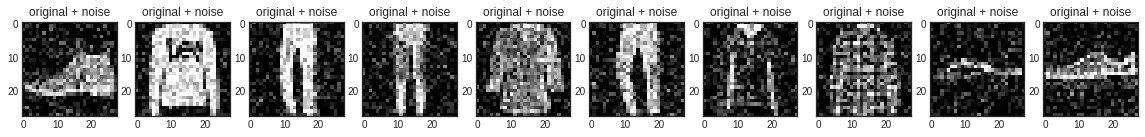

In [28]:
n = 10
plt.figure(figsize = (20,2))
for i in range(n):
    ax= plt.subplot(1,n, i+1)
    plt.title('original + noise')
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()

plt.show()

# 노이즈 성능이 확실하구만!


### 모델 정의

In [29]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()

        self.encoder = Sequential([Input(shape = (28,28,1)),
                                   Conv2D(16,(3,3), activation = 'relu', padding = 'same',strides = 2),
                                   Conv2D(8, (3,3), activation = 'relu', padding = 'same', strides = 2)])
        self.decoder = Sequential([Conv2DTranspose(8, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
                                   Conv2DTranspose(16, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
                                   Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding ='same')])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 모델 생성 및 컴파일

In [52]:
autoencoder = Denoise() # 오토인코더 개념이니까 이름 이렇게 지을게
autoencoder.compile(optimizer = 'adam', loss = MeanSquaredError())


In [53]:
print(x_train_noisy.shape)
print(x_train.shape)
print(x_test_noisy.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [54]:
type(x_train_noisy)

tensorflow.python.framework.ops.EagerTensor

In [55]:
type(x_train)

numpy.ndarray

In [56]:
type(x_test_noisy)

tensorflow.python.framework.ops.EagerTensor

In [57]:
type(x_test)

numpy.ndarray

### 모델 학습

In [58]:
autoencoder.fit(x_train_noisy, x_train,
                epochs = 10,
                shuffle = True,
                validation_data = (x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0190 - val_loss: 0.0111
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

### 인코더 요약

In [59]:
autoencoder.encoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


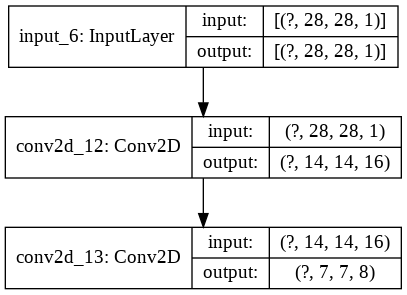

In [65]:
# plot_model(autoencoder.encoder)
import tensorflow as tf
# import matplotlib.pyplot as plt
# tf.keras.utils.plot_model(model, show_shapes = True)
tf.keras.utils.plot_model(autoencoder.encoder, show_shapes = True)

### 디코더 요약

In [69]:
autoencoder.decoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


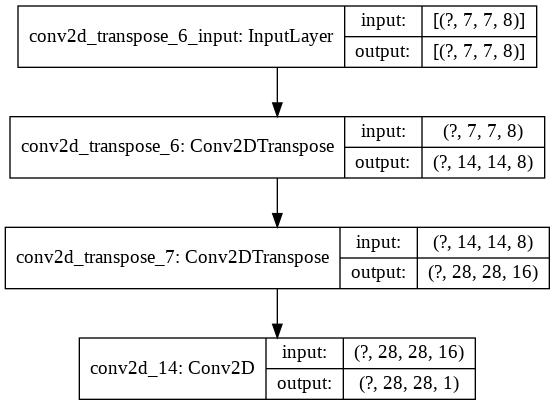

In [70]:
tf.keras.utils.plot_model(autoencoder.decoder, show_shapes = True)

In [67]:
type(x_test)

numpy.ndarray

In [68]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

### 노이즈가 있는 이미지와 없는 이미지 시각화

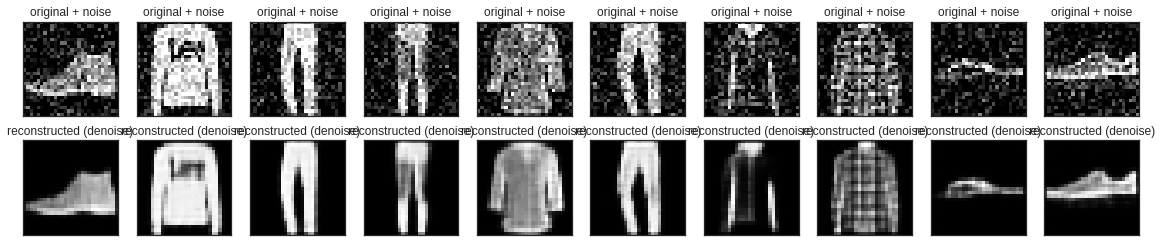

In [71]:
n = 10
plt.figure(figsize = (20,4))

for i in range(n):
    ax = plt.subplot(2,n, i+1)
    plt.title('original + noise')
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    bx = plt.subplot(2,n, i+1+n)
    plt.title('reconstructed (denoise)')
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

# 호옹이..성능 확실하구만..
# denoise 어때 , 노이즈가 다 제거됐구만
# 